### Clustering Based on Trajectory Analysis 

This notebook aims at identifying distinct patient subgroups within the AMP-PD dataset based on their UPDRS score progression over time. We only consider UPDRS scores before month 24 and only cluster patients with minimum 3 visits.
We use 4 clustering algorithms
- **K-Means** 
- **Hierarchial Aggolomerative**
- **Gaussian MIxture Models**
- **DBSCAN**

We use 3 scores to evaluate this algorithms and find the number of clusters 
- **Silhouette Score**
- **Calinski Harabasz Score**
- **Davies Bouldin Score** 

After clustering, we visualize the mean trajectory of each cluster along with the confidence interval for the whole time period.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import statsmodels.formula.api as sml
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import warnings
warnings.filterwarnings('ignore')


sns.set_style("whitegrid")

#### Initial Feature Preparation

We first set off a cut off month and only use data before this for our clustering.

In [2]:
cut_off_month = 24

In [3]:
patient_features = []
min_visits = 3
cleaned_updrs_scores= pd.read_csv("cleaned_updrs_scores.csv")

updrs_scores_till_cutoff = cleaned_updrs_scores[cleaned_updrs_scores['visit_month'] < cut_off_month]

for patient_id in updrs_scores_till_cutoff['participant_id'].unique():
    patient_data = updrs_scores_till_cutoff[
        updrs_scores_till_cutoff['participant_id'] == patient_id
    ].sort_values('visit_month')

    if len(patient_data) < min_visits:
        continue

    features = {'participant_id': patient_id}

    for updrs_type in ['updrs_1', 'updrs_2', 'updrs_3']:
        scores = patient_data[updrs_type].dropna()
        visits = patient_data.loc[scores.index, 'visit_month']

        if len(scores) >= 2:


            # Basic statistics
            features[f'{updrs_type}_mean'] = scores.mean()
            features[f'{updrs_type}_std'] = scores.std() if len(scores) > 1 else 0
            features[f'{updrs_type}_range'] = scores.max() - scores.min()

            # Progression metrics
            features[f'{updrs_type}_total_change'] = scores.iloc[-1] - scores.iloc[0]
            time_span = visits.iloc[-1] - visits.iloc[0]
            features[f'{updrs_type}_rate_of_change'] = (
                features[f'{updrs_type}_total_change'] / max(time_span, 1)
            )

            # Variability and trend
            if len(scores) >= 3:
                # Linear trend slope
                from scipy import stats
                slope, _, _, _, _ = stats.linregress(visits, scores)
                features[f'{updrs_type}_slope'] = slope

                # Coefficient of variation
                features[f'{updrs_type}_cv'] = scores.std() / scores.mean() if scores.mean() != 0 else 0
            else:
                features[f'{updrs_type}_slope'] = features[f'{updrs_type}_rate_of_change']
                features[f'{updrs_type}_cv'] = 0

            # Number of available measurements
        else:
            # Fill with NaN if insufficient data
            for suffix in [ '_mean', '_std', '_range',
                            '_total_change', '_rate_of_change', '_slope', '_cv']:
                features[f'{updrs_type}{suffix}'] = np.nan

    patient_features.append(features)
patient_features = pd.DataFrame(patient_features)

print(f"Created features for {len(patient_features)} patients")
print(f"Feature matrix shape: {patient_features.shape}")

# Show missingness
missing_pct = (patient_features.isnull().sum() / len(patient_features) * 100)
print(f"\nMissing data percentage by feature:")
for col, pct in missing_pct.items():
    if pct > 0 and col != 'participant_id':
        print(f"  {col}: {pct:.1f}%")
print("There is no missing data for all columns.")
        

Created features for 1055 patients
Feature matrix shape: (1055, 22)

Missing data percentage by feature:
There is no missing data for all columns.


#### Preparing Clustering Matrix

In [4]:
strategy = 'complete_cases'
scaler = StandardScaler()


print(f"\n=== PREPARING CLUSTERING MATRIX (strategy: {strategy}) ===")

feature_cols = [col for col in patient_features.columns if col != 'participant_id']


clustering_data = patient_features.copy()

print(f"Patients for clustering: {len(clustering_data)}")

# Prepare feature matrix
X = clustering_data[feature_cols].copy()



# Standardize features
X_scaled = scaler.fit_transform(X)

feature_matrix = X_scaled
clustering_patients = clustering_data['participant_id'].values

print(f"Final clustering matrix shape: {X_scaled.shape}")



=== PREPARING CLUSTERING MATRIX (strategy: complete_cases) ===
Patients for clustering: 1055
Final clustering matrix shape: (1055, 21)


In [5]:
def evaluate_clustering(labels, X, algorithm_name, n_clusters):
    """
    Evaluate clustering results using multiple metrics
    """
    # Skip evaluation for noise points in DBSCAN
    if len(np.unique(labels)) <= 1:
        return {
            'algorithm': algorithm_name,
            'n_clusters': len(np.unique(labels)),
            'silhouette_score': -1,
            'calinski_harabasz_score': -1,
            'davies_bouldin_score': float('inf'),
            'n_noise': np.sum(labels == -1) if -1 in labels else 0
        }

    # Remove noise points for evaluation (DBSCAN)
    if -1 in labels:
        mask = labels != -1
        X_clean = X[mask]
        labels_clean = labels[mask]
        n_noise = np.sum(labels == -1)
    else:
        X_clean = X
        labels_clean = labels
        n_noise = 0

    if len(np.unique(labels_clean)) <= 1:
        return {
            'algorithm': algorithm_name,
            'n_clusters': len(np.unique(labels)),
            'silhouette_score': -1,
            'calinski_harabasz_score': -1,
            'davies_bouldin_score': float('inf'),
            'n_noise': n_noise
        }

    return {
        'algorithm': algorithm_name,
        'n_clusters': len(np.unique(labels_clean)),
        'silhouette_score': silhouette_score(X_clean, labels_clean),
        'calinski_harabasz_score': calinski_harabasz_score(X_clean, labels_clean),
        'davies_bouldin_score': davies_bouldin_score(X_clean, labels_clean),
        'n_noise': n_noise
    }


#### Compare different clustering algorithms with various numbers of clusters

In [6]:
results = []

k_range = range(2,9)

# K-Means
print("Testing K-Means...")
for k in k_range:
    kmeans = KMeans(n_clusters=k,  n_init=10, random_state = 35)
    labels = kmeans.fit_predict(feature_matrix)
    results.append(evaluate_clustering(labels, feature_matrix, 'K-Means', k))

# Agglomerative Clustering
print("Testing Agglomerative Clustering...")
for k in k_range:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(feature_matrix)
    results.append(evaluate_clustering(labels, feature_matrix, 'Agglomerative', k))

# Gaussian Mixture Model
print("Testing Gaussian Mixture Model...")
for k in k_range:
    gmm = GaussianMixture(n_components=k,  random_state=35)
    labels = gmm.fit_predict(feature_matrix)
    results.append(evaluate_clustering(labels, feature_matrix, 'GMM', k))

# DBSCAN with different parameters
print("Testing DBSCAN...")
eps_values = [0.5, 1.0, 1.5, 2.0]
min_samples_values = [3, 5, 10]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(feature_matrix)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            result = evaluate_clustering(labels, feature_matrix, 'DBSCAN', n_clusters)
            result['eps'] = eps
            result['min_samples'] = min_samples
            results.append(result)


Testing K-Means...
Testing Agglomerative Clustering...
Testing Gaussian Mixture Model...
Testing DBSCAN...


#### Visualize clustering evaluation results

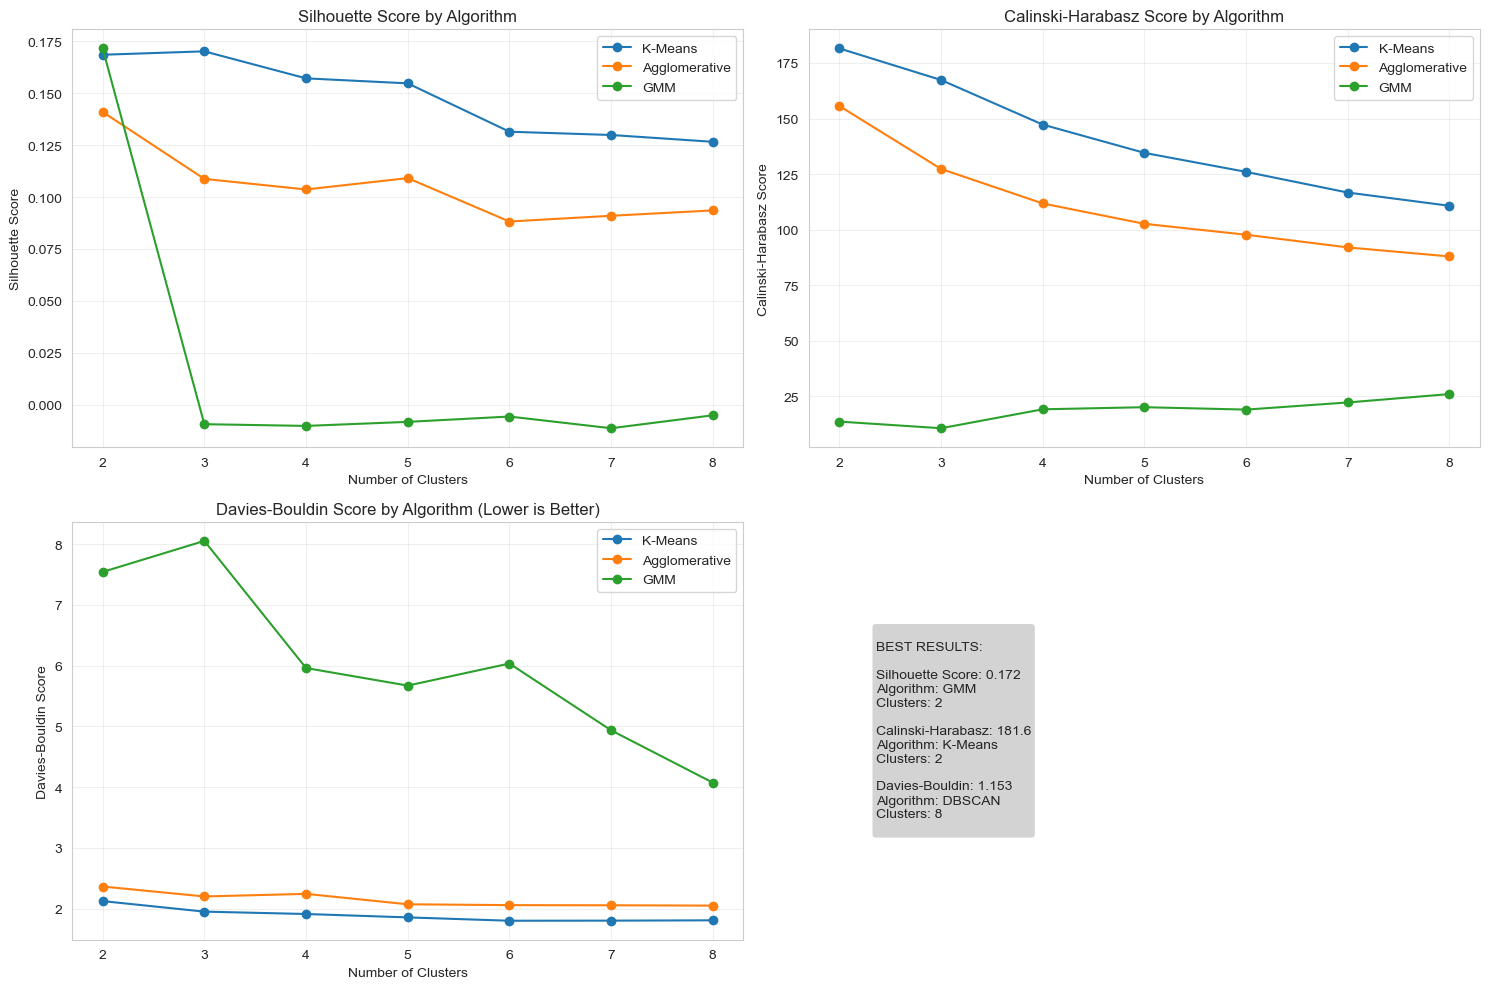

In [7]:
clustering_results = pd.DataFrame(results)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Filter out DBSCAN for cleaner visualization of k-based algorithms
k_based = clustering_results[clustering_results['algorithm'] != 'DBSCAN']

# Silhouette Score
for algo in k_based['algorithm'].unique():
    data = k_based[k_based['algorithm'] == algo]
    axes[0,0].plot(data['n_clusters'], data['silhouette_score'], 'o-', label=algo)
axes[0,0].set_xlabel('Number of Clusters')
axes[0,0].set_ylabel('Silhouette Score')
axes[0,0].set_title('Silhouette Score by Algorithm')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Calinski-Harabasz Score
for algo in k_based['algorithm'].unique():
    data = k_based[k_based['algorithm'] == algo]
    axes[0,1].plot(data['n_clusters'], data['calinski_harabasz_score'], 'o-', label=algo)
axes[0,1].set_xlabel('Number of Clusters')
axes[0,1].set_ylabel('Calinski-Harabasz Score')
axes[0,1].set_title('Calinski-Harabasz Score by Algorithm')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Davies-Bouldin Score (lower is better)
for algo in k_based['algorithm'].unique():
    data = k_based[k_based['algorithm'] == algo]
    axes[1,0].plot(data['n_clusters'], data['davies_bouldin_score'], 'o-', label=algo)
axes[1,0].set_xlabel('Number of Clusters')
axes[1,0].set_ylabel('Davies-Bouldin Score')
axes[1,0].set_title('Davies-Bouldin Score by Algorithm (Lower is Better)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Summary table of best results
axes[1,1].axis('off')

# Find best results for each metric
best_silhouette = clustering_results.loc[clustering_results['silhouette_score'].idxmax()]
best_calinski = clustering_results.loc[clustering_results['calinski_harabasz_score'].idxmax()]
best_davies = clustering_results.loc[clustering_results['davies_bouldin_score'].idxmin()]

summary_text = f"""
BEST RESULTS:

Silhouette Score: {best_silhouette['silhouette_score']:.3f}
Algorithm: {best_silhouette['algorithm']}
Clusters: {best_silhouette['n_clusters']}

Calinski-Harabasz: {best_calinski['calinski_harabasz_score']:.1f}
Algorithm: {best_calinski['algorithm']}
Clusters: {best_calinski['n_clusters']}

Davies-Bouldin: {best_davies['davies_bouldin_score']:.3f}
Algorithm: {best_davies['algorithm']}
Clusters: {best_davies['n_clusters']}
"""

axes[1,1].text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

plt.tight_layout()
plt.show()


In [8]:
weights={'silhouette': 0.33, 'calinski': 0.33, 'davies': 0.33}

#### Select optimal clustering based on weighted combination of metrics

In [9]:

# Normalize scores for comparison
df = clustering_results.copy()

# Normalize silhouette score (0 to 1, higher is better)
df['silhouette_norm'] = (df['silhouette_score'] - df['silhouette_score'].min()) / (df['silhouette_score'].max() - df['silhouette_score'].min())

# Normalize Calinski-Harabasz score (0 to 1, higher is better)
df['calinski_norm'] = (df['calinski_harabasz_score'] - df['calinski_harabasz_score'].min()) / (df['calinski_harabasz_score'].max() - df['calinski_harabasz_score'].min())

# Normalize Davies-Bouldin score (0 to 1, lower is better, so we invert)
df['davies_norm'] = 1 - ((df['davies_bouldin_score'] - df['davies_bouldin_score'].min()) / (df['davies_bouldin_score'].max() - df['davies_bouldin_score'].min()))

# Calculate weighted score
df['weighted_score'] = (
    weights['silhouette'] * df['silhouette_norm'] +
    weights['calinski'] * df['calinski_norm'] +
    weights['davies'] * df['davies_norm']
)

# Find optimal
optimal_idx = df['weighted_score'].idxmax()
optimal_result = df.loc[optimal_idx]

print(f"Optimal clustering:")
print(f"  Algorithm: {optimal_result['algorithm']}")
print(f"  Number of clusters: {optimal_result['n_clusters']}")
print(f"  Silhouette score: {optimal_result['silhouette_score']:.3f}")
print(f"  Calinski-Harabasz score: {optimal_result['calinski_harabasz_score']:.1f}")
print(f"  Davies-Bouldin score: {optimal_result['davies_bouldin_score']:.3f}")
print(f"  Weighted score: {optimal_result['weighted_score']:.3f}")


Optimal clustering:
  Algorithm: K-Means
  Number of clusters: 2
  Silhouette score: 0.169
  Calinski-Harabasz score: 181.6
  Davies-Bouldin score: 2.125
  Weighted score: 0.938


In [10]:
clustering_data

,participant_id,updrs_1_mean,updrs_1_std,updrs_1_range,updrs_1_total_change,updrs_1_rate_of_change,updrs_1_slope,updrs_1_cv,updrs_2_mean,updrs_2_std,...,updrs_2_rate_of_change,updrs_2_slope,updrs_2_cv,updrs_3_mean,updrs_3_std,updrs_3_range,updrs_3_total_change,updrs_3_rate_of_change,updrs_3_slope,updrs_3_cv
0,PP-3001,8.285714,1.799471,5.0,2.0,0.105263,0.159509,0.217178,2.714286,0.755929,...,0.105263,0.105317,0.278500,19.857143,5.209881,17.0,11.0,0.578947,0.621677,0.262368
1,PP-3002,8.285714,2.751623,9.0,2.0,0.105263,-0.015849,0.332092,12.714286,3.638419,...,0.473684,0.348671,0.286168,21.714286,3.039424,10.0,-1.0,-0.052632,0.173313,0.139973
2,PP-3003,11.428571,2.507133,8.0,3.0,0.157895,0.053170,0.219374,5.714286,2.563480,...,0.368421,0.262781,0.448609,35.142857,6.256425,18.0,14.0,0.736842,0.716769,0.178028
3,PP-3006,2.166667,1.169045,3.0,0.0,0.000000,-0.044586,0.539559,9.000000,2.756810,...,0.153846,0.267516,0.306312,28.000000,5.549775,13.0,13.0,1.000000,0.978344,0.198206
4,PP-3010,10.285714,1.976047,5.0,2.0,0.105263,0.130879,0.192116,13.571429,4.237025,...,0.736842,0.558793,0.312202,25.285714,9.214378,28.0,28.0,1.473684,1.243865,0.364410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,SU-33407,7.750000,3.095696,7.0,-6.0,-0.333333,-0.350000,0.399445,13.750000,1.707825,...,-0.055556,-0.116667,0.124205,38.500000,8.386497,18.0,2.0,0.111111,-0.166667,0.217831
1051,SU-33408,15.333333,4.509250,9.0,4.0,0.333333,0.333333,0.294082,16.666667,2.516611,...,-0.250000,-0.250000,0.150997,18.333333,8.082904,16.0,-6.0,-0.500000,-0.500000,0.440886
1052,SU-33502,3.500000,3.316625,7.0,-7.0,-0.388889,-0.400000,0.947607,8.000000,2.943920,...,0.111111,0.033333,0.367990,21.500000,5.802298,14.0,14.0,0.777778,0.733333,0.269874
1053,SU-33504,4.000000,1.732051,3.0,-3.0,-0.250000,-0.250000,0.433013,4.333333,1.527525,...,0.250000,0.250000,0.352506,15.666667,2.081666,4.0,1.0,0.083333,0.083333,0.132872


In [11]:
optimal_result

algorithm                     K-Means
n_clusters                          2
silhouette_score             0.168555
calinski_harabasz_score    181.556779
davies_bouldin_score         2.125012
n_noise                             0
eps                               NaN
min_samples                       NaN
silhouette_norm              0.984711
calinski_norm                     1.0
davies_norm                  0.859064
weighted_score               0.938446
Name: 0, dtype: object

Cluster distribution:
  Cluster 0: 426 patients
  Cluster 1: 629 patients


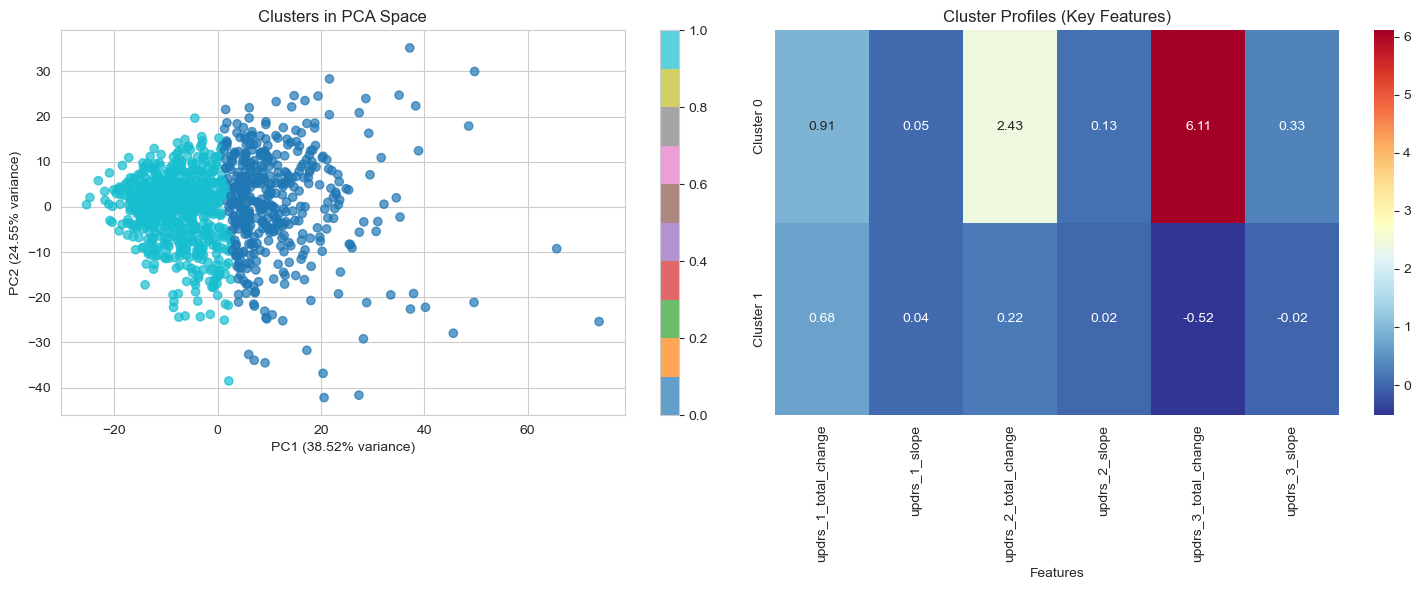

In [12]:
"""
Apply the optimal clustering and visualize results
"""

# Apply the optimal clustering algorithm
if optimal_result['algorithm'] == 'K-Means':
    model = KMeans(n_clusters=int(optimal_result['n_clusters']), random_state=35, n_init=10)
elif optimal_result['algorithm'] == 'Agglomerative':
    model = AgglomerativeClustering(n_clusters=int(optimal_result['n_clusters']), linkage='ward')
elif optimal_result['algorithm'] == 'GMM':
    model = GaussianMixture(n_components=int(optimal_result['n_clusters']), random_state=35)
elif optimal_result['algorithm'] == 'DBSCAN':
    model = DBSCAN(eps=optimal_result['eps'], min_samples=3)

labels = model.fit_predict(X)

# Create results dataframe
results_df = pd.DataFrame({
    'participant_id': clustering_patients,
    'cluster': labels
})

print(f"Cluster distribution:")
cluster_counts = pd.Series(labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    cluster_name = 'Noise' if cluster == -1 else f'Cluster {cluster}'
    print(f"  {cluster_name}: {count} patients")

# Visualize clusters using PCA
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title('Clusters in PCA Space')
plt.colorbar(scatter, ax=axes[0])

# Cluster characteristics heatmap
# Get original features for interpretation
feature_names = [col for col in patient_features.columns if col != 'participant_id']
original_features = patient_features[feature_names].fillna(patient_features[feature_names].median())

cluster_profiles = []
for cluster in sorted(set(labels)):
    if cluster != -1:  # Skip noise
        mask = labels == cluster
        profile = original_features.iloc[mask].mean()
        cluster_profiles.append(profile)

if cluster_profiles:
    cluster_df = pd.DataFrame(cluster_profiles, index=[f'Cluster {i}' for i in range(len(cluster_profiles))])

    # Select key features for visualization
    key_features = [col for col in cluster_df.columns if any(x in col for x in ['_baseline', '_slope', '_total_change'])]

    if key_features:
        sns.heatmap(cluster_df[key_features], annot=True, fmt='.2f', cmap='RdYlBu_r', ax=axes[1])
        axes[1].set_title('Cluster Profiles (Key Features)')
        axes[1].set_xlabel('Features')

plt.tight_layout()
plt.show()

In [13]:
cluster_df

,updrs_1_mean,updrs_1_std,updrs_1_range,updrs_1_total_change,updrs_1_rate_of_change,updrs_1_slope,updrs_1_cv,updrs_2_mean,updrs_2_std,updrs_2_range,...,updrs_2_rate_of_change,updrs_2_slope,updrs_2_cv,updrs_3_mean,updrs_3_std,updrs_3_range,updrs_3_total_change,updrs_3_rate_of_change,updrs_3_slope,updrs_3_cv
Cluster 0,8.530673,2.625313,6.302817,0.909624,0.049079,0.047730,0.392001,10.892874,2.915303,7.026995,...,0.133699,0.129050,0.327141,31.909071,6.780647,16.323944,6.105634,0.354937,0.334351,0.228829
Cluster 1,5.863866,2.042039,4.750397,0.679650,0.040632,0.043785,0.470348,5.586960,1.903683,4.427663,...,0.011695,0.015048,0.412511,16.726482,4.062064,9.560413,-0.517488,-0.027265,-0.024649,0.257417


In [14]:
results_df.head()

,participant_id,cluster
0,PP-3001,1
1,PP-3002,1
2,PP-3003,0
3,PP-3006,0
4,PP-3010,0


In [15]:
updrs_scores_with_clusters = results_df.merge(
    cleaned_updrs_scores,
    on='participant_id',
    how='left'
)

In [16]:
updrs_scores_with_clusters.head()

,participant_id,cluster,updrs_1,updrs_2,updrs_3,visit_month
0,PP-3001,1,7.0,2.0,18.0,-1
1,PP-3001,1,8.0,2.0,12.0,0
2,PP-3001,1,7.0,2.0,18.0,3
3,PP-3001,1,7.0,3.0,23.0,6
4,PP-3001,1,8.0,3.0,19.0,9


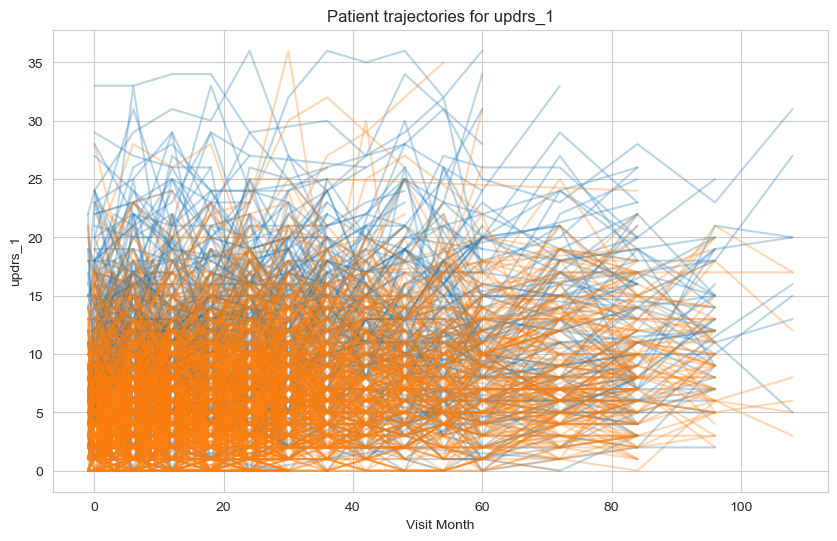

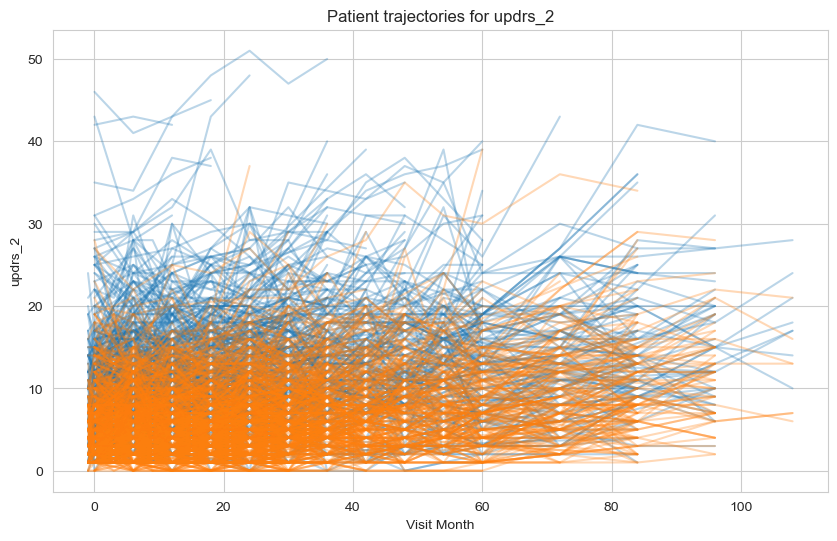

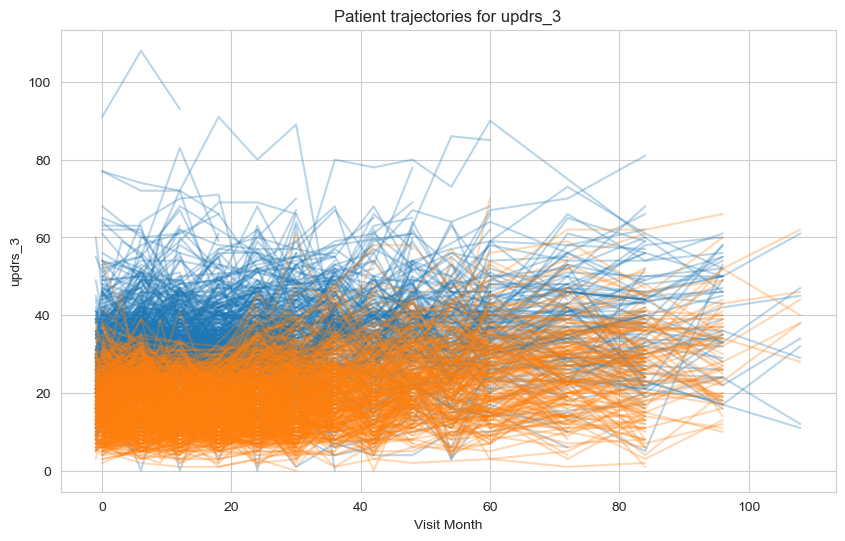

In [17]:
palette = sns.color_palette("tab10", optimal_result['n_clusters'])

# Generate separate plots for each UPDRS score
for score in ['updrs_1', 'updrs_2', 'updrs_3']:
    plt.figure(figsize=(10, 6))
    plt.title(f"Patient trajectories for {score}")

    # Plot individual patient trajectories within each cluster
    for cluster_id, cluster_data in updrs_scores_with_clusters.groupby('cluster'):
        for pid, patient_data in cluster_data.groupby('participant_id'):
            plt.plot(
                patient_data['visit_month'],
                patient_data[score],
                color=palette[int(cluster_id)],
                alpha=0.3
            )

    plt.xlabel('Visit Month')
    plt.ylabel(score)
    plt.show()


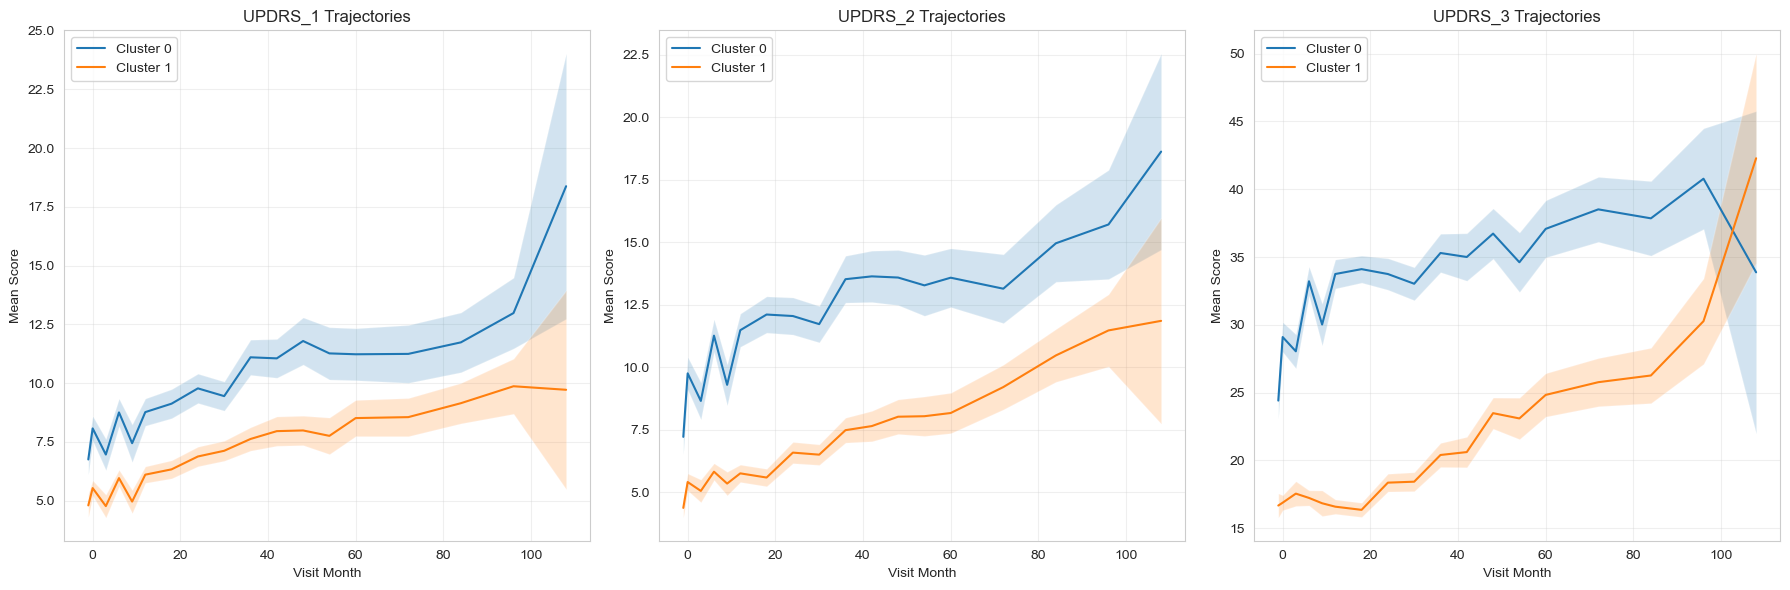

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
updrs_scores = ['updrs_1', 'updrs_2', 'updrs_3']

for i, updrs in enumerate(updrs_scores):
    ax = axes[i]
    
    # Calculate mean and 95% CI per cluster per month
    cluster_means = []
    for cluster_id, cluster_data in updrs_scores_with_clusters.groupby('cluster'):
        monthly_means = cluster_data.groupby('visit_month')[updrs].mean()
        monthly_std = cluster_data.groupby('visit_month')[updrs].std()
        monthly_count = cluster_data.groupby('visit_month')[updrs].count()
        
        # Calculate 95% CI
        ci = 1.96 * monthly_std / np.sqrt(monthly_count)
        
        cluster_means.append({
            'cluster': cluster_id,
            'months': monthly_means.index,
            'mean': monthly_means.values,
            'ci_lower': monthly_means.values - ci.values,
            'ci_upper': monthly_means.values + ci.values
        })
    
    # Plot each cluster
    for cm in cluster_means:
        ax.plot(cm['months'], cm['mean'], label=f'Cluster {cm["cluster"]}')
        ax.fill_between(
            cm['months'], 
            cm['ci_lower'], 
            cm['ci_upper'], 
            alpha=0.2
        )
    
    ax.set_title(f'{updrs.upper()} Trajectories')
    ax.set_xlabel('Visit Month')
    ax.set_ylabel('Mean Score')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [19]:
updrs_scores_with_clusters.to_csv("cluster_data.csv", index = False)

We thus obtain 2 clusters, we will explore the biological relevance of this clusters in the subsequent notebooks.